# EX14 프로젝트 : 주식 예측에 도전해 보자

### 학습 목표

-----------------------

* 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
* ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.
* 실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

### ✅ 목차

-------------------

**STEP 1** : 시계열 데이터 준비

**STEP 2** : 각종 전처리 수행

**STEP 3** : 시계열 안정성 분석

**STEP 4** : 학습, 테스트 데이터셋 생성

**STEP 5** : 적정 ARIMA 모수 찾기

**STEP 6** : ARIMA 모델 훈련과 테스트

**STEP 7** : 다른 주식 종목 예측해 보기

---------------------

### STEP 1 : 시계열 데이터 준비

------------------------------

* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있음.
* 종가(Close)만 사용하겠음 (주식 시장은 정해진 시간 동안만 거래가 가능. 종가란 하루의 장이 마감하였을 때의 가격.)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import os


In [3]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [4]:
# Time Series 생성
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
# 여러 데이터 중에 종가(주식 시장이 마감했을 때의 주식 가격)만 사용
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행   

------------------------------

* 결측치 처리
* 로그 변환

In [5]:
# 결측치 처리
# 결측치가 있다면 이를 보간하기, 보간 기준은 time을 선택
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [6]:
# 로그 변환 시도 
ts_log = np.log(ts)

### STEP 3 : 시계열 안정성 분석

------------------------------------

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

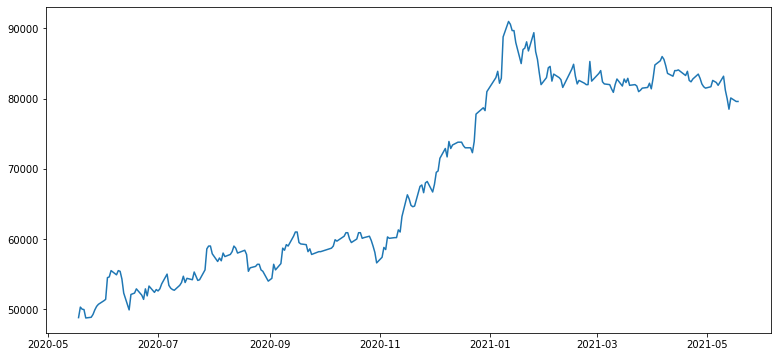

In [7]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize']=13, 6

plt.plot(ts)

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

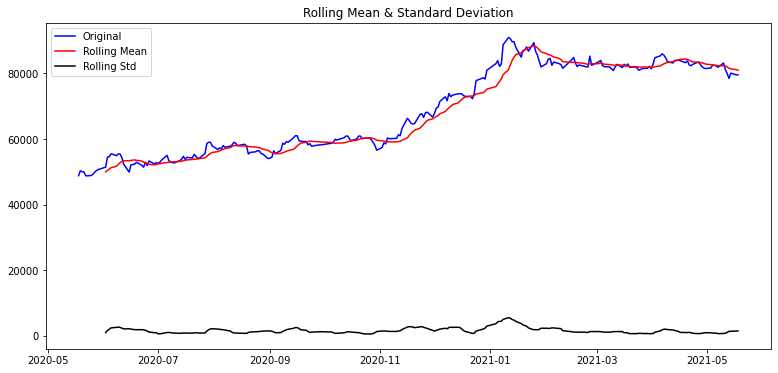

In [9]:
plot_rolling_statistics(ts, window=12)

statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지이다.

아래는 statsmodels 패키지에서 제공하는 **adfuller 메소드를 이용**해 주어진 **timeseries**에 대한 **Augmented Dickey-Fuller Test**를 수행하는 코드

In [10]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [11]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


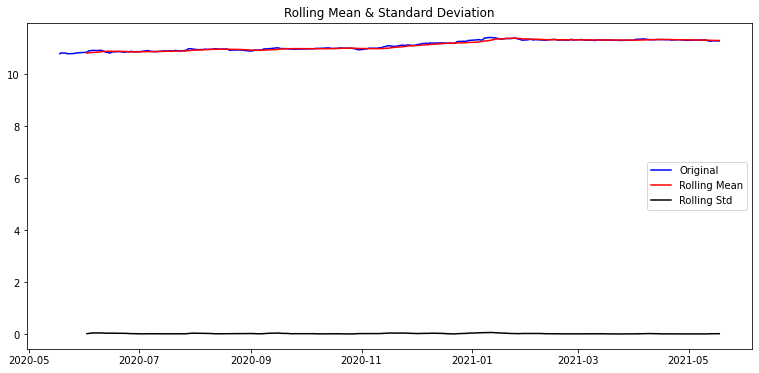

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


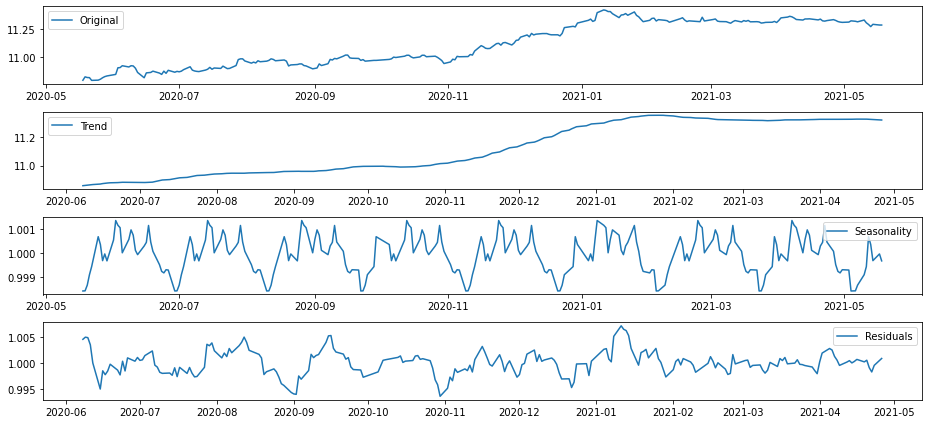

In [12]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [13]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

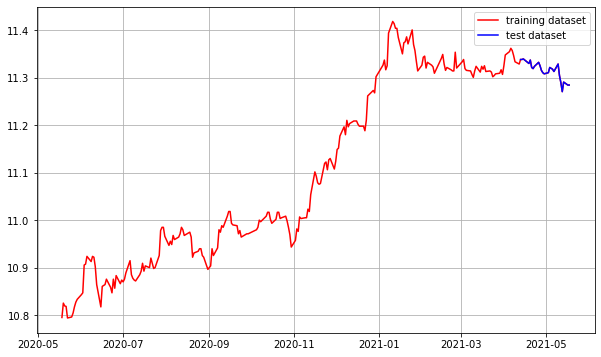

In [14]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

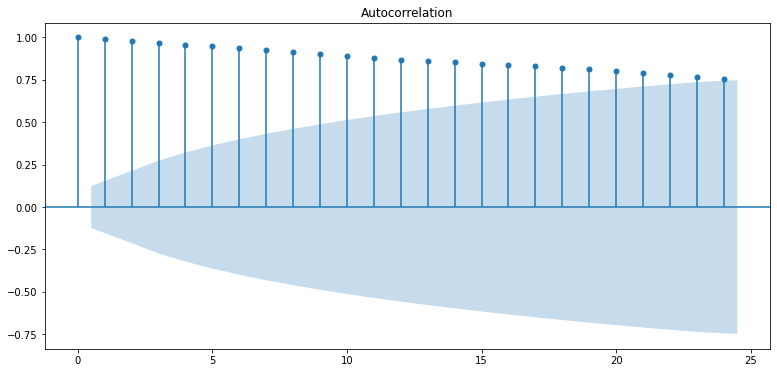

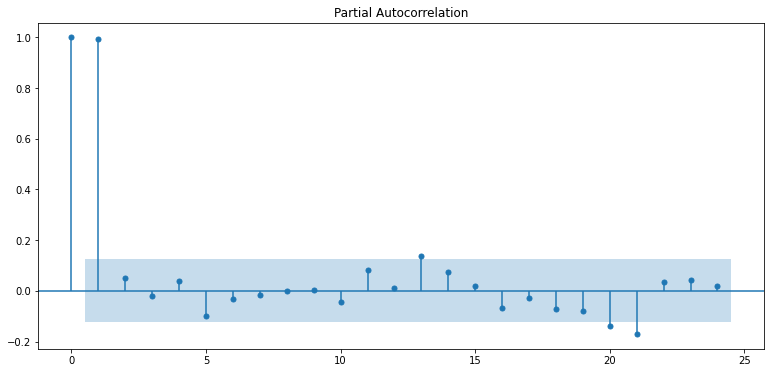

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


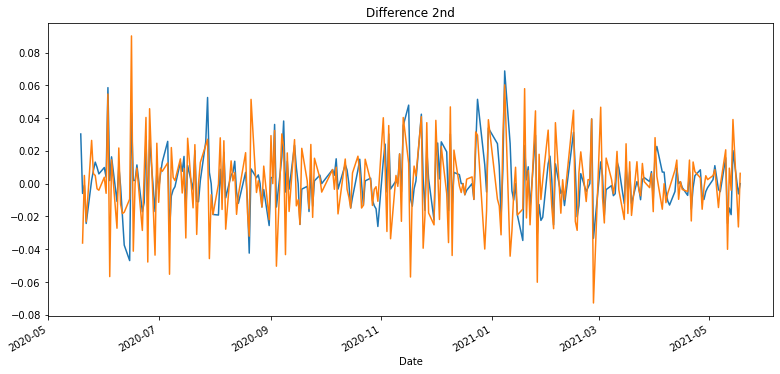

In [16]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [17]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1164.792
Time:                        08:55:42   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

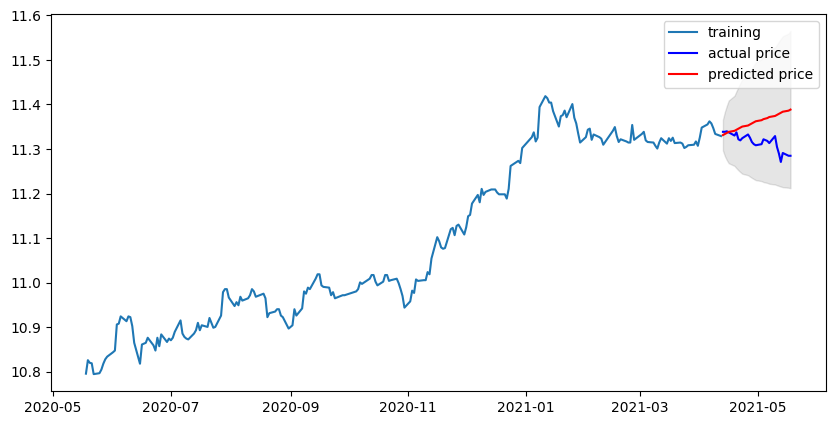

In [18]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


## STEP 7 : 다른 주식 종목 예측해 보기 

--------------

#### 1) kakao
#### 2) netflix
#### 3) naver
----------------------

### 1) kakao
**카카오**에대한 주식을 예측해보겠습니다!

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/new_data/kakao.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-07    78400.0
2020-09-08    78000.0
2020-09-09    76800.0
2020-09-10    77100.0
2020-09-11    75800.0
Name: Close, dtype: float64

In [3]:
# 결측치 처리
# 결측치가 있다면 이를 보간하기, 보간 기준은 time을 선택
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [4]:
# 로그 변환 시도 
ts_log = np.log(ts)

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.079773
p-value                          0.964653
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


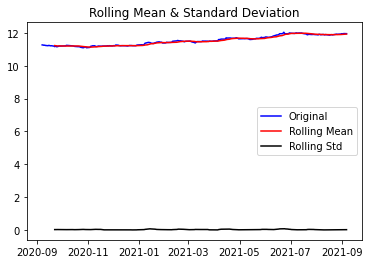

Results of Dickey-Fuller Test:
Test Statistic                  -0.033064
p-value                          0.955711
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


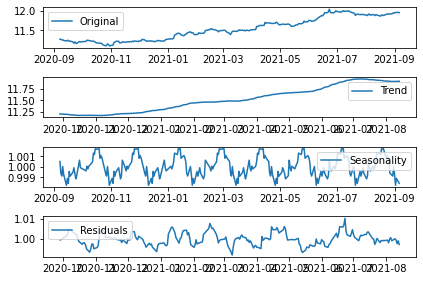

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.176713
p-value                          0.000010
#Lags Used                       1.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


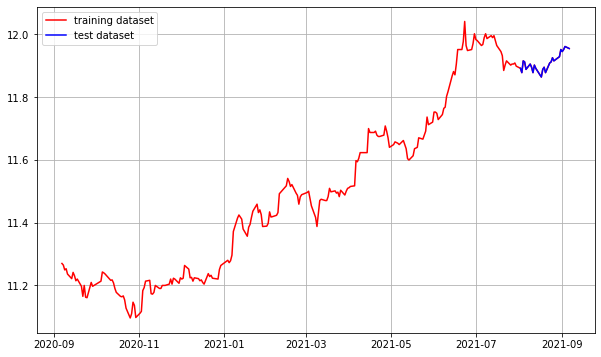

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

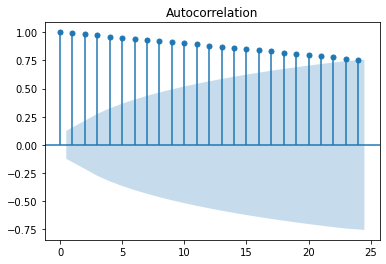

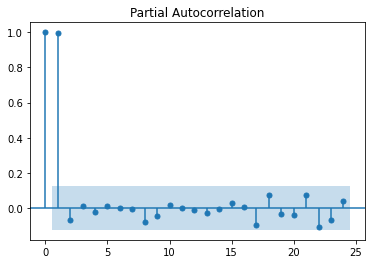

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.472499e+01
p-value                        2.714872e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.314052e+00
p-value                        3.721895e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


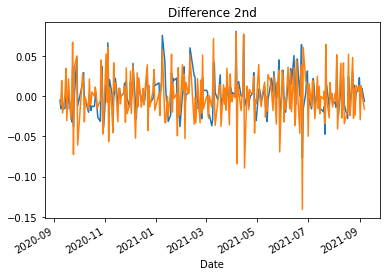

In [12]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 530.013
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 07 Sep 2021   AIC                          -1054.027
Time:                        09:59:29   BIC                          -1043.819
Sample:                             1   HQIC                         -1049.906
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0028      0.002      1.734      0.083      -0.000       0.006
ar.L1.D.Close     0.0841      0.067      1.259      0.208      -0.047       0.215
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측

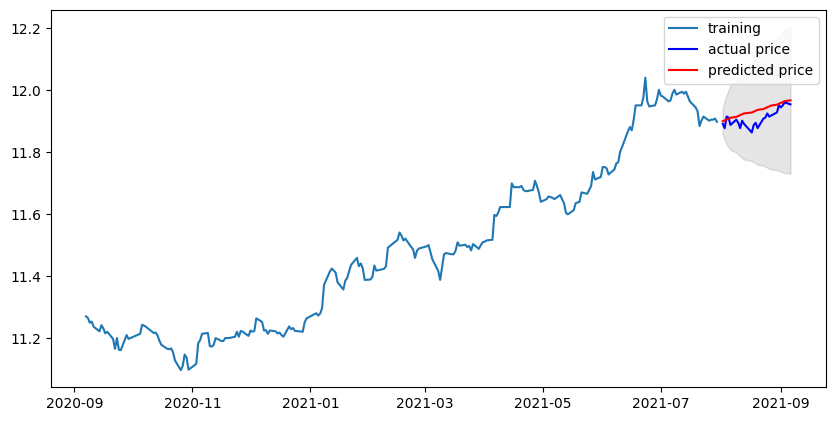

In [14]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있음. 
np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산하자

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  19357558.080198396
MAE:  3720.091829664252
RMSE:  4399.722500362766
MAPE: 2.53%


2.53%로 잘 예측이 된 것 같다.

## 2) Netflix

netflix도 예측을 해보겠습니다.

In [3]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/new_data/NFLX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-08    507.019989
2020-09-09    500.190002
2020-09-10    480.670013
2020-09-11    482.029999
2020-09-14    476.260010
Name: Close, dtype: float64

In [4]:
# 결측치 처리
# 결측치가 있다면 이를 보간하기, 보간 기준은 time을 선택
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.853206
p-value                          0.051066
#Lags Used                       4.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


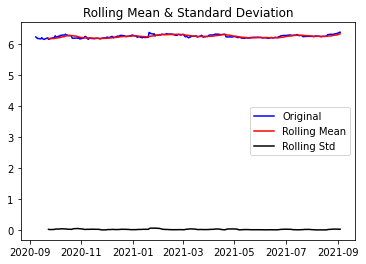

Results of Dickey-Fuller Test:
Test Statistic                  -2.880521
p-value                          0.047660
#Lags Used                       4.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


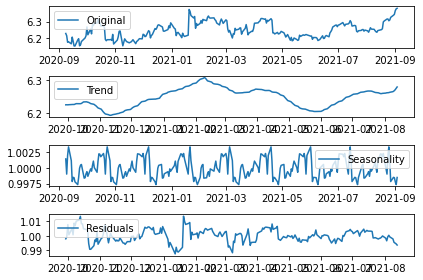

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.840038e+00
p-value                        3.796297e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.200000e+02
Critical Value (1%)           -3.460428e+00
Critical Value (5%)           -2.874769e+00
Critical Value (10%)          -2.573821e+00
dtype: float64


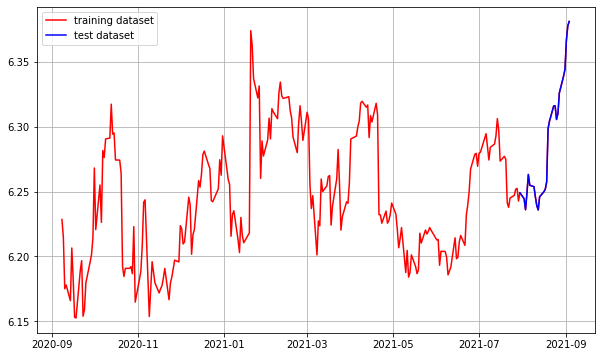

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

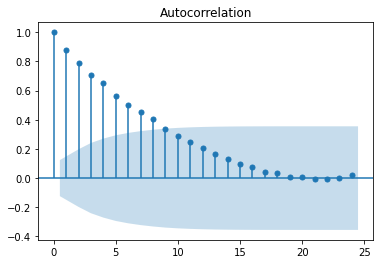

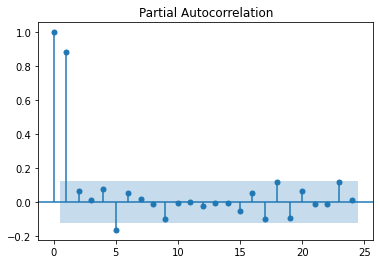

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.561079e+00
p-value                        3.008962e-11
#Lags Used                     4.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.461340e+00
p-value                        1.440701e-08
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


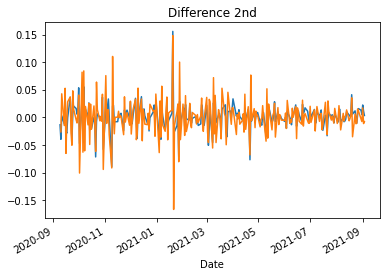

In [13]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [27]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 526.421
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 07 Sep 2021   AIC                          -1046.842
Time:                        10:22:57   BIC                          -1036.607
Sample:                             1   HQIC                         -1042.711
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.684e-05      0.001      0.057      0.954      -0.003       0.003
ar.L1.D.Close    -0.1494      0.066     -2.264      0.024      -0.279      -0.020
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

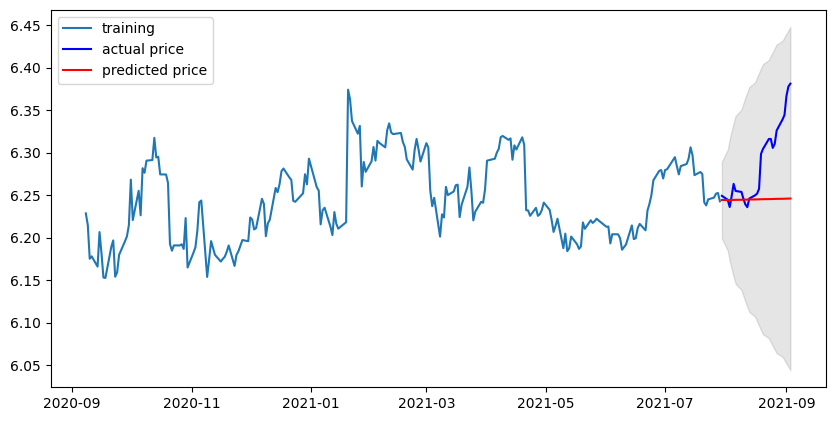

In [28]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1137.6862032107447
MAE:  23.540680179551018
RMSE:  33.729604255175374
MAPE: 4.18%


모수를 한번 바꿔보겠습니다.

[참고](https://data-newbie.tistory.com/39)

모형의 식별에서  P,Q 를 간결의 원칙으로 인해 P <3 , Q < 3으로 선택하는 것이 가장 좋다
모형 개수가 증가하면 예측 모형이 복잡해질 뿐 아니라 추정의 효율성도 떨어지기 때문이다. 
그래서 웬만하면 모수의 개수가 적은 모형이 좋다.

p=1, d=1, q=1

In [27]:
from statsmodels.tsa.arima_model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 529.976
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 07 Sep 2021   AIC                          -1051.952
Time:                        11:36:09   BIC                          -1038.305
Sample:                             1   HQIC                         -1046.444
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      0.889      0.374      -0.000       0.000
ar.L1.D.Close     0.8748      0.033     26.145      0.000       0.809       0.940
ma.L1.D.Close    -1.0000      0.016    -

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


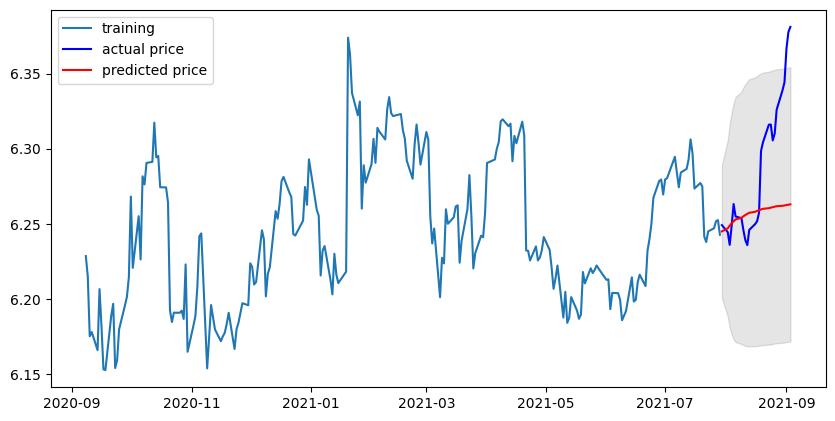

In [28]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  810.7808147407894
MAE:  19.979585034934537
RMSE:  28.474213154023932
MAPE: 3.55%


## 3) Naver

In [30]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/new_data/naver.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-07    314500.0
2020-09-08    311000.0
2020-09-09    304500.0
2020-09-10    307500.0
2020-09-11    306000.0
Name: Close, dtype: float64

In [31]:
# 결측치 처리
# 결측치가 있다면 이를 보간하기, 보간 기준은 time을 선택
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [32]:
# 로그 변환 시도 
ts_log = np.log(ts)

In [35]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -0.376075
p-value                          0.914017
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


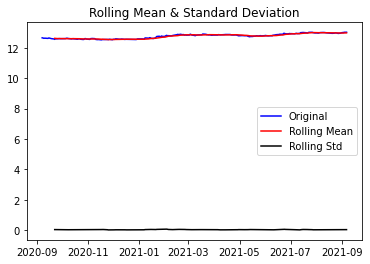

Results of Dickey-Fuller Test:
Test Statistic                  -0.350788
p-value                          0.917997
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


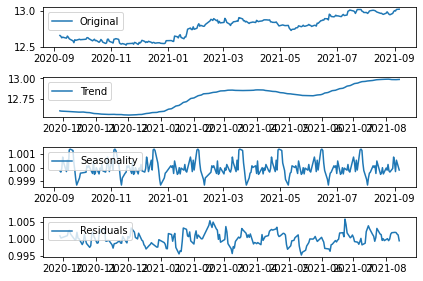

In [36]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [37]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.629220e+00
p-value                        5.771542e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


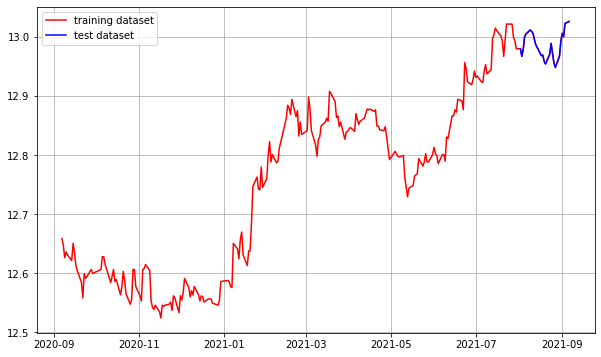

In [38]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

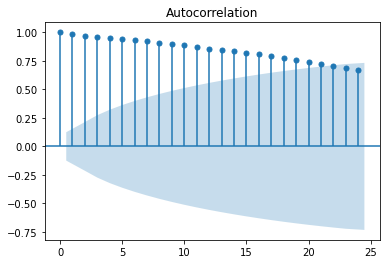

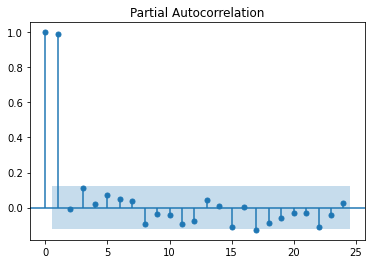

In [39]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.269325e+01
p-value                        1.120256e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.945369e+00
p-value                        1.000415e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


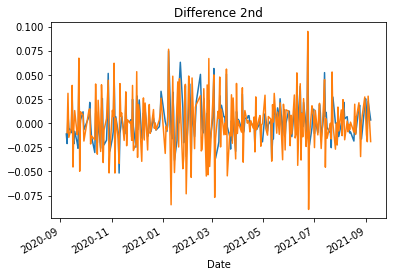

In [40]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [42]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 545.646
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 07 Sep 2021   AIC                          -1085.292
Time:                        10:31:41   BIC                          -1075.084
Sample:                             1   HQIC                         -1081.170
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      1.072      0.284      -0.001       0.004
ar.L1.D.Close    -0.0285      0.067     -0.426      0.670      -0.160       0.103
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

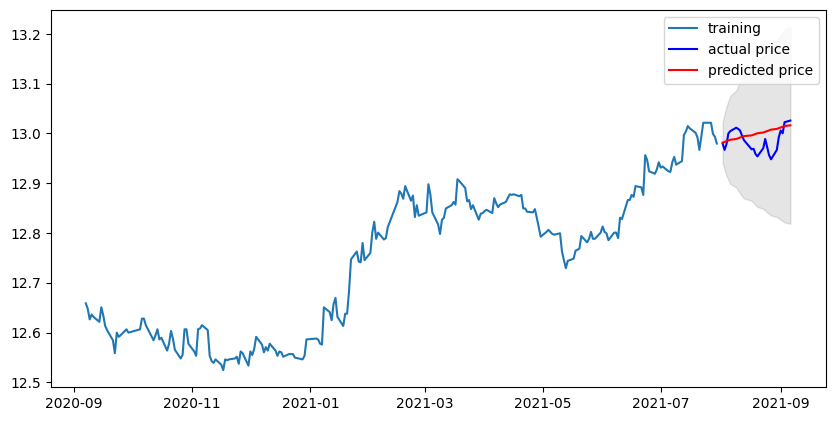

In [43]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  136749736.94864967
MAE:  9598.722259287522
RMSE:  11694.004316257528
MAPE: 2.23%


15%미만으로 나왔다.

# 🌟루브릭

|평가문항|상세기준|
|:------|:------|
|1. 시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

# 🌟 회고

넷플릭스로 했을 때 10%이하였긴 하지만 모수를 변경해보면서 값을 줄여보았다.    
p=3, d=1, q=0와  p=2, d=1, q=1 이런식으로 바꿔보았고, 
p=1, d=1, q=1일 때 시도했던 것보다 좀 더 값이 줄어드는 것을 볼 수 있었음.   
주식을 예측한다는 것 자체가 흥미로웠던 exploration이였지만 ARIMA라던지 개념정리가 더 필요하다고 느꼈다.

## ✅ 내용 추가 정리

#### ARIMA (Autogressive Integrated Moving Average)
* 대표적인 통계적 시계열 예측 모형으로, 현재값을 과거값과 과거 예측 오차를 통해 설명한다.
* ARIMA 모형은 비정상 시계열을 설명하려는 모형
* ARMA 모형은 평균으로 회귀하도록 예측하는데 반해, ARIMA 모형은 추세 쪽으로 회귀하도록 예측
* 과거의 데이터가 지니고 있던 '추세(Momentum)'까지 반영한다. 
* Correlation뿐만 아니라 Cointegration까지 고려한 모델이다.
    * Correlation은 서로간에 선형관계를 설명하는 것이라면 Cointegration은 추세관계를 설명한다. 즉, Cointegration인 시점이 고려되지 않으면 성립하지 않기 때문에 시계열 데이터에만 쓰이는 개념임
    
#### AR(Autoregression) 모델
* 자기 회귀모델이라고 불리는 모델이다. 자기 자신의 과거를 사용하기 때문에 이러한 이름이 붙은 것이다. 이전의 자신의 관측값이 이후의 자신의 관측값에 영향을 준다는 아이디어의 모형이다 (RNN의 아이디어와 매우 유사하다). 

#### MA(Moving Average) 모델
* 이동 평균 모델은 트렌드(평균 혹은 시계열 그래프에서의 y값)가 변화하는 상황에서 적합한 회귀모델이다.

#### ARMA 모형
* ARMA 모형은 AR 모형과 MA 모형을 혼합한 모형이다. 현재 시계열 데이터는 과거 시계열 데이터들과 과거 잔차들의 조합으로 설명된다는 모형이다.

[ARIMA 참고1](https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80)

[ARIMA 참고2](https://m.blog.naver.com/bluefish850/220749045909)

[참고3](https://be-favorite.tistory.com/63)

[참고4](https://yamalab.tistory.com/112)

[참고 5](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=fininsight&logNo=221516817114)